In this lab we will use hourly usage volumes of the New York City bike share system as a time series to predict.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

print(tf.__version__)


2.1.0


TODO: the below storage bucket should go to a general public bucket that can be maintained accessible for the purpose of this lab.

The below csv file is the csv export (via Google Drive) of the following query:

```
select datetime_trunc(starttime, hour) starttime, count(*) trips
from `bigquery-public-data.new_york_citibike.citibike_trips` 
where starttime is not null and starttime < '2016-09-27'
group by 1 order by 1
```

We also convert the string containing a timestamp to a `datetime` timestamp, and set is as the dataframe index.




In [2]:
df = pd.read_csv("https://storage.googleapis.com/dsparing-lstm/citibike_trips_hourly.csv")
df["starttime"] = pd.to_datetime(df["starttime"])
df = df.set_index('starttime')
print(df.shape)
df.head()

(28301, 1)


,trips
starttime,
2013-07-01 00:00:00,229
2013-07-01 01:00:00,106
2013-07-01 02:00:00,74
2013-07-01 03:00:00,41
2013-07-01 04:00:00,37


In [3]:
pd.date_range(min(df.index), max(df.index), freq="1h").shape

(28416,)

Our dataset contains less rows than the the number of hours between its earliest and latest hour -- this is because there are also hours where no bike trips were initiated. In order to create a proper time series, we need to insert these missing hours as new rows:

In [4]:
idx = pd.date_range(min(df.index), max(df.index), freq="1h") # lab todo
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(idx, fill_value = 0)
df.index.name = "starttime"
print(df.shape)
df.head()

(28416, 1)


,trips
starttime,
2013-07-01 00:00:00,229
2013-07-01 01:00:00,106
2013-07-01 02:00:00,74
2013-07-01 03:00:00,41
2013-07-01 04:00:00,37


In the following we will closely follow the [Time series forecasting tutorial on tensorflow.org](https://www.tensorflow.org/tutorials/structured_data/time_series). The following function generates the training dataset given the desired past history size and future target size:

In [5]:
# from https://www.tensorflow.org/tutorials/structured_data/time_series
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i:i+target_size])
  return np.array(data), np.array(labels)

We will set the number of rows going into the training set, the rest will be our validation dataset.

In [6]:
TRAIN_SPLIT = 20000
tf.random.set_seed(13)

Let's visualize our dataset:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7121bbbeb8>],
      dtype=object)

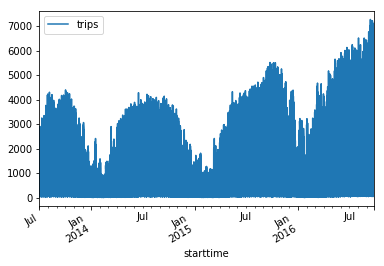

In [7]:
df.plot(subplots = True)

We will normalize our data, however, we should only calculate the statistics on our training set to avoid data leakage.

In [8]:
uni_data = df.values

In [9]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [10]:
uni_data = (uni_data-uni_train_mean)/uni_train_std


Set below the desired past history window to be used, in the above example two weeks (experiment with changing it to possibly improve predictions) as well as the length of the predicted target window.

In [11]:
past_history = 2*24*7 # two weeks, lab todo
future_target = 24-1 # one day

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

In [12]:
print ('Single window of past history')
print (x_train_uni[0].shape)
print ('\n Target value to predict')
print (y_train_uni[0].shape)

Single window of past history
(336, 1)

 Target value to predict
(23, 1)


In [13]:
def create_time_steps(length):
  return list(range(-length, 0))

In [14]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

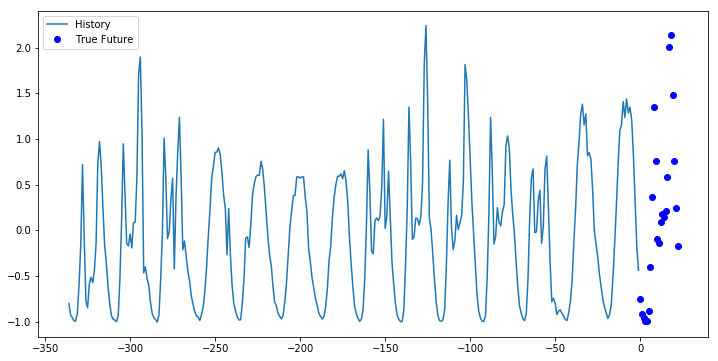

In [15]:
multi_step_plot(x_train_uni[0], y_train_uni[0], np.array([0]))

In [16]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Here we create our LSTM model, do change its architecture (number of units, a second LSTM layer, different optimizer) to explore models with different predictive performance.

In [17]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, # lab todo parameters
                         input_shape=x_train_uni.shape[-2:]), 
    tf.keras.layers.Dense(future_target)
])

lstm_model.compile(optimizer="adam", loss='mae') # lab todo


In [18]:
for x, y in val_univariate.take(1):
    print(lstm_model.predict(x).shape)

(256, 23)


Below we train our model, do adjust the evaluation interval and epochs to arrive at a smoothly decreasing evaluation loss.

In [19]:
EVALUATION_INTERVAL = 50
EPOCHS = 10

lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 50 steps, validate for 50 steps
Epoch 1/10
50/50 [==============================] - 33s 650ms/step - loss: 0.7703 - val_loss: 0.9922
Epoch 2/10
50/50 [==============================] - 29s 588ms/step - loss: 0.7373 - val_loss: 0.9339
Epoch 3/10
50/50 [==============================] - 31s 619ms/step - loss: 0.6722 - val_loss: 0.8563
Epoch 4/10
50/50 [==============================] - 32s 642ms/step - loss: 0.5728 - val_loss: 0.8002
Epoch 5/10
50/50 [==============================] - 31s 619ms/step - loss: 0.5447 - val_loss: 0.7467
Epoch 6/10
50/50 [==============================] - 31s 622ms/step - loss: 0.4977 - val_loss: 0.7062
Epoch 7/10
50/50 [==============================] - 31s 614ms/step - loss: 0.4458 - val_loss: 0.6786
Epoch 8/10
50/50 [==============================] - 31s 613ms/step - loss: 0.4475 - val_loss: 0.6485
Epoch 9/10
50/50 [==============================] - 30s 602ms/step - loss: 0.4171 - val_loss: 0.6327
Epoch 10/10
50/50 [==============================

Finally, plot some sample predictions:

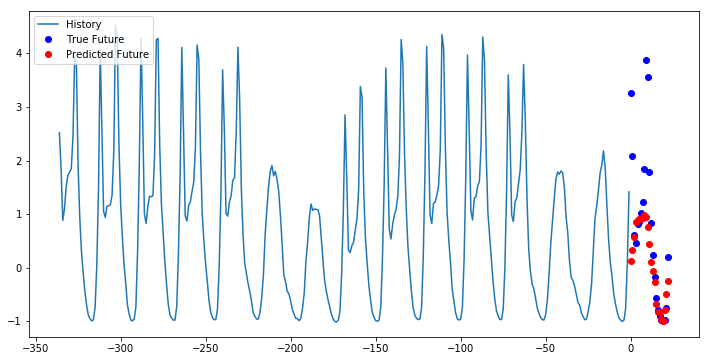

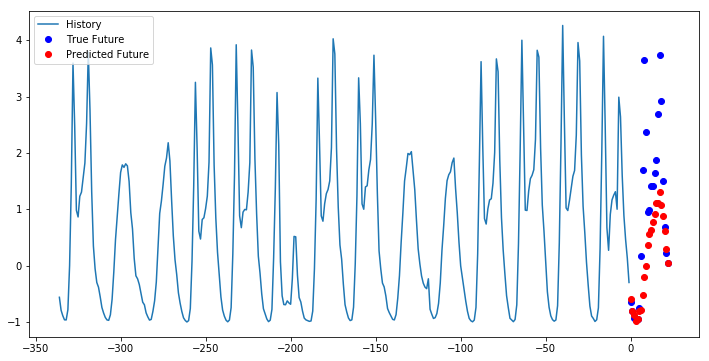

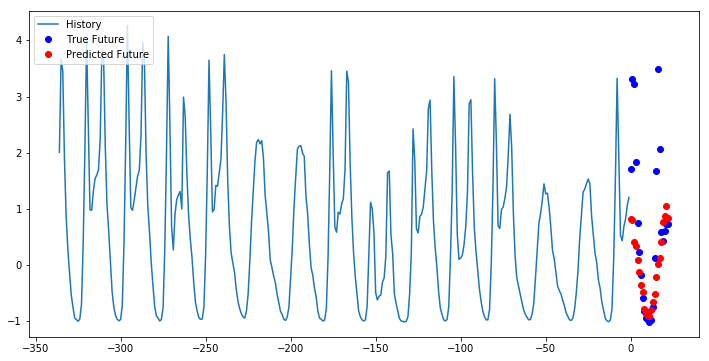

In [20]:
for x, y in val_univariate.take(3):
  plot = multi_step_plot(x[0].numpy(),
                    y[0].numpy(),
                    lstm_model.predict(x)[0])